# Membrane vibrations

## Description

The membrane dynamics arise from the principle of conservation of linear momentum, which is essentially Newton's equation for a membrane represented by a domain Ω in the plane. The code aims to represent the oscillation of membranes under tension occupying a region of the x−y plane.

## Getting started

The projects has some requirements for its full operation.

### Pre-requisites

* Python

```bash
sudo apt-get install python3
```

* PostgreSQL

```bash
sudo apt-get install postgresql
```

## Implementation

### Step 1

Implement the Francis method. To do this, use the scipy.linalg.qr function, which returns the matrices of the QR factorization. Test the method on randomly generated symmetric matrices of increasing dimensions (e.g., n=10,50,100,200). Measure the computation time as a function of n.

#### Building Matrizes

In [1]:
import numpy as np
import scipy.sparse

# Building the global index
def ij2n (i, j, N):
    return i + j*N

def BuildMatrizesEigen(N1, N2, sigma, rho, e, delta):
    nunk = N1*N2
    
    # Stiffness matrix K: Build it as a sparse matrix
    d1 = 4.0*np.ones(nunk)
    d2 = -np.ones(nunk-1)
    d3 = -np.ones(nunk-N1)
    K = (sigma/delta**2)*scipy.sparse.diags([d3, d2, d1, d2, d3],
        [-N1, -1, 0, 1, N1], format='csr')
    # Force the eigenvalues associated to boundary points
    # to be a big number as compared to fundamental modes
    big_number = 10000
    Iden = big_number*scipy.sparse.identity(nunk, format='csr')
    
    # Lados verticais
    for k in range(0,N2):
        Ic = ij2n(0,k,N1) # Left
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        Ic = ij2n(N1-1,k,N1) # Right
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Lados horizontais
    for k in range(0,N1):
        Ic = ij2n(k,0,N1) # Bottom
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        Ic = ij2n(k,N2-1,N1) # Top
        K[Ic,:], K[:,Ic] = Iden[Ic,:], Iden[:,Ic]
        
    # Mass matrix: Simple case, multiple of identity
    M = rho * e * scipy.sparse.identity(nunk, format='csr')

    return K, M

#### Implementing Francis Method

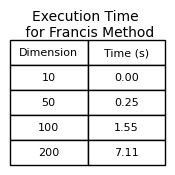

In [2]:
import numpy as np
import scipy.linalg
import time
import matplotlib.pyplot as plt

def francisMethod(A, MAX_ITER, TOL):
    n = A.shape[0]
    k = 1
    Vk = np.eye(n)
    Ak = A

    epsilon = np.inf
    while epsilon > TOL and k < MAX_ITER:
        # 1. Calculate the factoration QR of Ak
        Qk, Rk = scipy.linalg.qr(Ak)
        
        # 2. Define Ak+1 = Rk Qk
        Ak = np.dot(Rk, Qk)
        
        # 3. Vk+1 = Vk Qk
        Vk = np.dot(Vk, Qk)
        
        # 4. Calculate the error
        epsilon = np.max(np.abs(np.triu(Ak, 1)))
        
        k += 1

    return Ak, Vk

# Stores times in a list
times = []

# Test the method in randomical simetrical increasing matrizes
dimensions = [10, 50, 100, 200]
for n in dimensions:
    A = np.random.rand(n, n)
    A = np.dot(A, A.T)
    MAX_ITER = 1000
    TOL = 1e-6
    start_time = time.time()
    francisMethod(A, MAX_ITER, TOL)
    end_time = time.time()
    execution_time = end_time - start_time
    times.append(execution_time)

# Build the table using matplotlib
plt.figure(figsize=(2, 1))
plt.axis('off')

table_data = []
for i, n in enumerate(dimensions):
    table_data.append([n, f"{times[i]:.2f}"])

header = ['Dimension', 'Time (s)']
table = plt.table(cellText=table_data, colLabels=header, loc='center', cellLoc='center', fontsize=10)
table.scale(1, 1.5)  # Ajustar tamanho da célula

title_text = 'Execution Time \n for Francis Method'
title_fontsize = 10  # Ajustar tamanho do título proporcionalmente ao tamanho da tabela

plt.title(title_text, fontsize=title_fontsize, pad=20)  # Ajustar tamanho do título
plt.show()


#### Step 2

Design a method to build a square matrix of dimension 𝑛 that has a known spectrum (e.g., the eigenvalues could be the numbers 1, 2, 3, ..., 𝑛). Now, use the function scipy.linalg.eigh to calculate the eigenvalues and verify that they match the expected values.

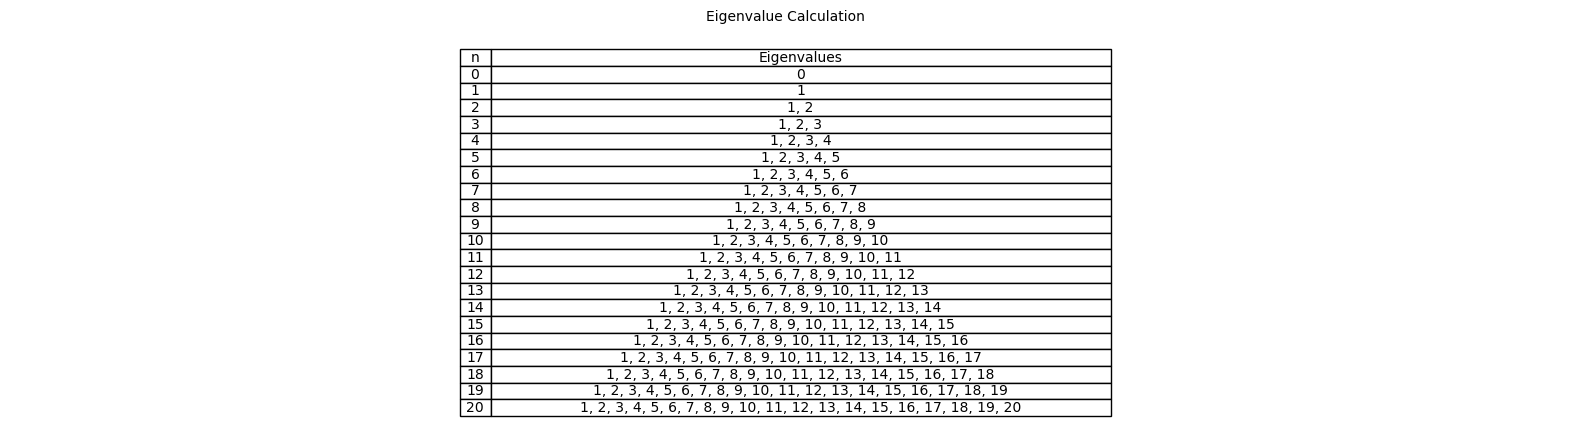

In [3]:
import numpy as np
from scipy.linalg import eigh
import matplotlib.pyplot as plt

def buildMatrixWithKnownSpectrum(n):
    if n == 0:
        return np.zeros((1, 1))  # Returns a 1x1 empty matrix
    else:
        eigenvalues = np.arange(1, n+1)
        matrix = np.diag(eigenvalues)
        return matrix

def calculateEigenvalues(matrix):
    if matrix.size == 0:  # Checks if the matrix is empty
        return [0]  # Returns [0] for n equals 0
    else:
        eigenvalues, _ = eigh(matrix)
        return np.round(eigenvalues).astype(int)  # Rounds and converts to integers

nValues = range(21)
eigenvaluesList = []

for n in nValues:
    matrix = buildMatrixWithKnownSpectrum(n)
    calculatedEigenvalues = calculateEigenvalues(matrix)
    calculatedEigenvaluesStr = ', '.join(map(str, calculatedEigenvalues))
    eigenvaluesList.append(calculatedEigenvaluesStr)

# Printing the table using Matplotlib
fig, ax = plt.subplots(figsize=(20, 0.01))
ax.axis('tight')
ax.axis('off')
tableData = [["n", "Eigenvalues"]] + [[n, eigenvalues] for n, eigenvalues in zip(nValues, eigenvaluesList)]
table = ax.table(cellText=tableData, colWidths=[0.02, 0.4], cellLoc='center')
table.auto_set_font_size(False)

titleText = 'Eigenvalue Calculation'
titleFontSize = 10  # Adjust title size proportionally to the table size

plt.title(titleText, fontsize=titleFontSize, pad=20)  # Adjust title size

plt.show()


According to the data provided by the table for different values of n, it is observed that the expected eigenvalues have been found. Therefore, the function is correctly implemented.

#### Step 3

Show that 2 is indeed a solution to evolution problem 1.

In [11]:
def calculateEigenvalues(matrix):
    if matrix.size == 0:
        return [0]
    else:
        eigenvalues, _ = np.linalg.eigh(matrix)
        return eigenvalues

def compareEigenvalues(n, MAX_ITER, TOL):
    # Generate a matrix with known spectrum
    A = buildMatrixWithKnownSpectrum(n)
    
    # Calculate the eigenvalues using the Francis method
    francisEigenvalues, _ = francisMethod(A, MAX_ITER, TOL)
    francisEigenvalues = np.diag(francisEigenvalues)  # Get the diagonal
    
    # Calculate the eigenvalues using the calculateEigenvalues function
    scipyEigenvalues = calculateEigenvalues(A)
    
    # Calculate the error between the eigenvalues
    error = np.linalg.norm(francisEigenvalues - scipyEigenvalues)
    
    return error

# Parameters
dimensions = [10, 50, 100, 200]
MAX_ITER = 1000
TOL = 1e-6

# Test for different dimensions
for n in dimensions:
    error = compareEigenvalues(n, MAX_ITER, TOL)
    print(f"For n = {n}, the error between the eigenvalues is {error}.")


For n = 10, the error between the eigenvalues is 0.0.
For n = 50, the error between the eigenvalues is 0.0.
For n = 100, the error between the eigenvalues is 0.0.
For n = 200, the error between the eigenvalues is 0.0.


Thus, it is verified that solution 2 is also the solution to evolution problem 4.1.

## Author

<table>
    <td align="center" style="border: none;">
      <a href="https://www.linkedin.com/in/guaraujoc/" title="LinkedIn">
        <img src="https://avatars.githubusercontent.com/u/130992375?s=400&u=168448c320a3ad61a9737a30880fa942249baedc&v=4" width="100px;"  style="border-radius: 50%;"><br>
        <sub>
          <b>Gustavo Araújo<br></b>
        </sub>
      </a>
    </td>
</table>

## License

Distributed under the MIT License. See [MIT License](https://opensource.org/license/MIT) for more information.